In [3]:
from pathlib import Path
import plotly.express as px
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
import sys
sys.path.append(str(Path.cwd().parent))
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs

In [4]:
from ivtk.alg.spaceiv import spaceiv

In [5]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({
    "figure.figsize": [7.50, 4.50],
    "figure.autolayout": True,
    "text.usetex": False,
    "font.family": "sans-serif",
    'font.size': 16
})

In [6]:
PARCS_CONFIG_DIR = Path('src') / 'data' / 'parcs_simulation' / 'config'

In [7]:
entity, project = "jasmineqy0", "formal_3"  

In [8]:
run_path = 'jasmineqy0/formal_3/zbwji1m3'
dfiv_model = load_dfiv_model(run_path)

# Demand Original

In [9]:
from src.data.demand_design import psi, f

In [10]:
group = 'dfiv_low_dim_parcs_revise'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]

# original_test_loss = runs_df['summary'].apply(lambda x: x['min_test_loss']).tolist()
# original_rho = runs_df['config'].apply(lambda x: x['data_configs']['rho']).tolist()
# # original_data_size = runs_df['config'].apply(lambda x: x['data_configs']['data_size'])
# len(original_test_loss), len(original_rho)

In [ ]:
# group = 'dfiv_low_dim_hetero_stage_2'
# runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
# runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]
# runs_df = runs_df[runs_df['summary'].apply(lambda x: x['min_test_loss'] < 5e3)]
# runs_df = runs_df.iloc[:162, :]

# hetero_test_loss = runs_df['summary'].apply(lambda x: x['min_test_loss']).tolist()
# hetero_rho = runs_df['config'].apply(lambda x: x['data_configs']['rho']).tolist()
# len(hetero_test_loss), len(hetero_rho)

(162, 162)

In [88]:
fig = px.box(runs_df, x="rho", y="test_loss",
            #  facet_col="data_size",
             log_y=True, points="all", boxmode="overlay"
             category_orders = {'rho': [0.1, 0.3, 0.5, 0.7, 0.9], 'data_size': [1000, 5000, 10000]},
             labels = {'rho': r'$\rho$', 'data_size': 'Data Size', 'test_loss': 'MSE'})
# fig.update_layout(width=10)
# fig.update_layout(boxgap=0)
fig.update_xaxes(type='category')
fig.update_traces(quartilemethod="exclusive")
fig.update_yaxes(range = [2,4])
fig.show()
fig.write_image("images/demand_original.pdf")

## CATE

In [ ]:
num_point = 50

In [ ]:
# vary t: fix p = 25, S = E[S]
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price_val = 25
price = np.ones(num_point) * price_val
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [ ]:
true_demand = f(price, time, emotion)
price = price[:, np.newaxis]
pred_demand = predict_dfiv_model(dfiv_model, price, covariate)

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

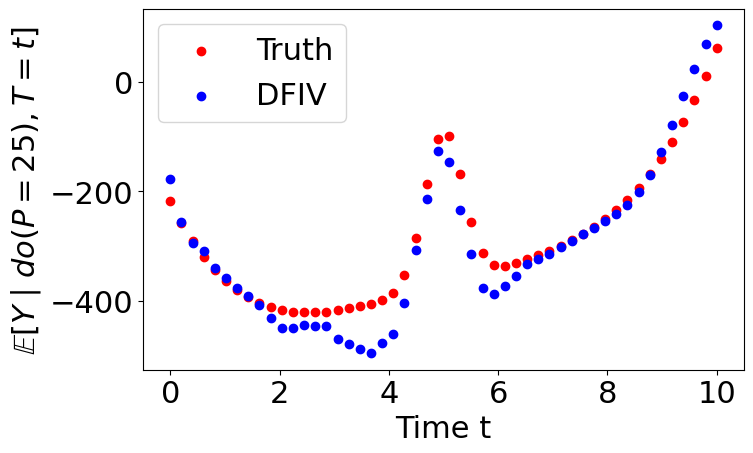

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
time = time.squeeze()
l1 = ax.scatter(time, true_demand, color='red', label='Truth')
l2 = ax.scatter(time, pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Time t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=25), T=t]$')
# plt.savefig(f'{img_dir}/CATE hst2.pdf')
plt.savefig("images/CATE_demand_original.pdf")
plt.show()

## ATE

In [ ]:
num_point = 50

In [ ]:
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price = np.ones(num_point) * np.linspace(10, 25, num_point)
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [ ]:
G = np.mean(psi(time)) * np.mean(emotion_range)
coef = G - 2
offset = 100 + 10 * G

true_demand = coef * price + offset

In [ ]:
pred_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_model, p, covariate)))
    pred_demand.append(pred)

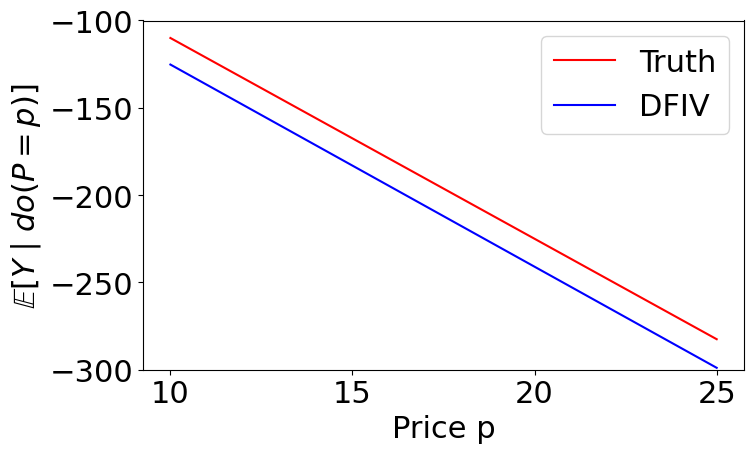

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
price = price.squeeze()
fig.set_figheight(5)
fig.set_figwidth(8)
l1 = ax.plot(price, true_demand, color='red', label='Truth')
l2 = ax.plot(price, pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Price p')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
ax.set_ylim([-300, -100])
# plt.savefig(f'{img_dir}/CATE hst2.pdf')
plt.savefig("images/ATE_demand_original.pdf")
plt.show()


# Demand Revised

In [ ]:
# from src.data.demand_design import psi, f
from src.data.demand_design_parcs_revise import psi, f

In [ ]:
run_path = 'jasmineqy0/dfiv_demand_search/kytpqqlu'
dfiv_model = load_dfiv_model(run_path)

In [ ]:
group = 'dfiv_low_dim_parcs_revise_1'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]

In [ ]:
revised_test_loss = runs_df['summary'].apply(lambda x: x['test loss'])
revised_rho = runs_df['config'].apply(lambda x: x['data_configs']['rho'])
revised_data_size = runs_df['config'].apply(lambda x: x['data_configs']['data_size'])

revised_df = pd.DataFrame({'rho': original_rho, 'data_size': revised_data_size, 'test_loss': revised_test_loss})
revised_df = revised_df.dropna(subset=['rho'])
revised_df

,rho,data_size,test_loss
0,0.9,10000,4600.174316
1,0.9,10000,6157.083496
2,0.9,10000,4218.197266
3,0.9,10000,1930.087891
4,0.9,10000,1373.994507
...,...,...,...
175,0.1,10000,442061.843750
176,0.1,10000,1780.394287
177,0.1,10000,199116.390625
178,0.1,10000,866.486084


In [ ]:
# fig = px.box(revised_df, x="rho", y="test_loss", facet_col="data_size",
#              log_y=True, points="all",
#              category_orders = {'rho': [0.1, 0.5, 0.9], 'data_size': [1000, 5000, 10000]},
#              labels = {'rho': r'$\rho$', 'data_size': 'Data Size', 'test_loss': 'MSE'},
#              boxmode='overlay')
# # fig.update_layout(width=10)
# # fig.update_layout(boxgap=0)
# fig.show()
# fig.write_image("images/demand_original.pdf")

## CATE

In [ ]:
num_point = 50

In [ ]:
# vary t: fix p = 25, S = E[S]
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price_val = 25
price = np.ones(num_point) * price_val
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [ ]:
true_demand = f(price, time, emotion)
price = price[:, np.newaxis]
pred_demand = predict_dfiv_model(dfiv_model, price, covariate)

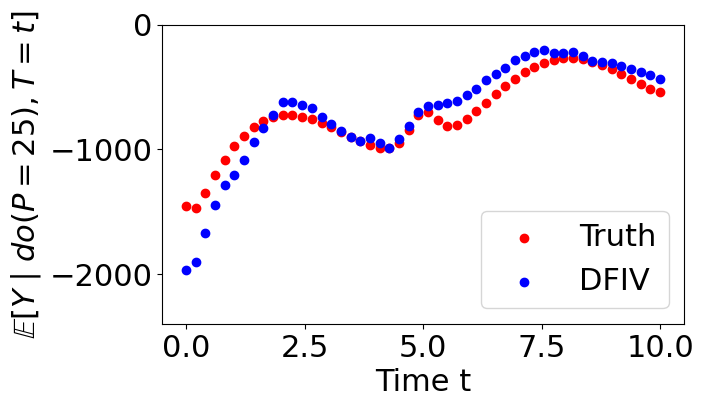

In [ ]:
fig, ax = plt.subplots()
time = time.squeeze()
l1 = ax.scatter(time, true_demand, color='red', label='Truth')
l2 = ax.scatter(time, pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Time t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=25), T=t]$')
ax.set_ylim([-2400, 0])
plt.savefig(f'images/CATE_demand_revised.pdf')
plt.show()

## ATE

In [ ]:
num_point = 50

In [ ]:
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price = np.ones(num_point) * np.linspace(10, 25, num_point)
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [ ]:
G = np.mean(psi(time)) * np.mean(emotion_range)
coef = G - 2
offset = 100 + 10 * G

true_demand = coef * price + offset

In [ ]:
pred_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_model, p, covariate)))
    pred_demand.append(pred)

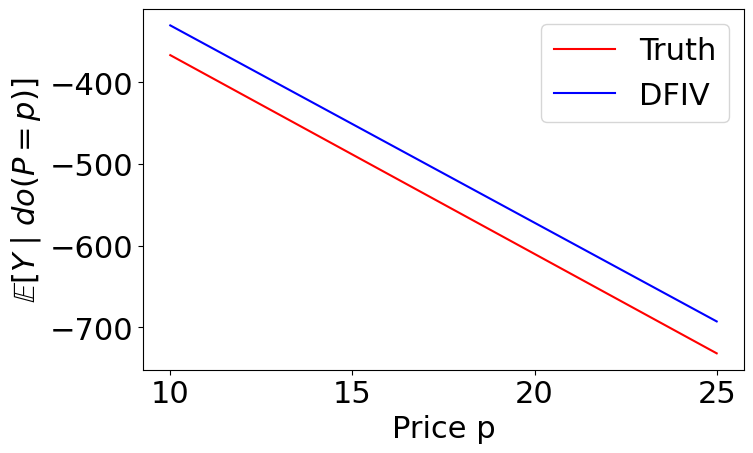

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
price = price.squeeze()
fig.set_figheight(5)
fig.set_figwidth(8)
l1 = ax.plot(price, true_demand, color='red', label='Truth')
l2 = ax.plot(price, pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Price p')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
# plt.savefig(f'{img_dir}/CATE hst2.pdf')
plt.savefig(f'images/ATE_demand_revised.pdf')
plt.show()


In [ ]:
# # vary p: fix t = E[t] = 5, S = E[S] = 4
# emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price_val = np.linspace(10, 25, num_point)
# price = np.ones(num_point) * price_val
# time = np.array([5] * num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [ ]:
# true_demand = f(price, time, emotion)
# price = price[:, np.newaxis]
# pred_demand = predict_dfiv_model(dfiv_model, price, covariate)

In [ ]:
# fig, ax = plt.subplots()
# price = price.squeeze()
# l1 = ax.plot(price, true_demand, color='red', label='Truth')
# l2 = ax.plot(price, pred_demand, color='blue', label='DFIV')
# ax.legend()

# ax.set_xlabel('Time of the year t')
# ax.set_ylabel('ATE')
# ax.set_ylim([-1000, 200])
# # plt.savefig(f'{img_dir}/CATE hst2.pdf')
# plt.show()

## spaceIV

In [ ]:
from src.data.demand_design_parcs_revise import generate_train_demand_design_parcs_revise
import os

In [ ]:
# Get the current working directory
prev_dir = os.getcwd()
print("Prev working directory:", prev_dir)

# Change the working directory
os.chdir("../")

# Check the new working directory
print("Updated working directory:", os.getcwd())

In [ ]:
# deadloop, invertible matrix
valid_seed = get_valid_seed()

In [ ]:
get_valid_seed


In [ ]:
def get_valid_seed():
    seed = 0
    valid = False
    while not valid:
        try: 
            train_data = generate_train_demand_design(data_size=5000, rho=0.5, rand_seed=seed)
            I = train_data.instrumental
            covariate = train_data.covariate
            treatment = train_data.treatment
            X = np.c_[covariate, treatment]
            Y = train_data.outcome
            beta_placeholder = np.zeros((X.shape[1], 1))
            beta_hat, _ = spaceiv(I, X, Y, beta_placeholder)
            valid = True
        except Exception as e:
            seed += 1
            print(e)
    print(f'Valid seed: {seed}')
    return seed